In [1]:
%env DGLBACKEND=tensorflow
import dgl
import tensorflow as tf
import matplotlib.pyplot as plt

env: DGLBACKEND=tensorflow


2022-04-27 02:07:46.609125: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/manisb/opt/anaconda3/envs/ml-project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = dgl.data.CiteseerGraphDataset()

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:
graph = dataset[0]
adj = graph.adjacency_matrix()

features = graph.ndata['feat']
labels = graph.ndata['label']

feature_len = features.shape[1]
node_len = features.shape[0]
label_len = tf.unique(labels)[0].shape[0]

random_cate_dist = tf.random.categorical(tf.math.log([[0, 0.1, 0.2, 0.7]]), node_len)

train_mask = random_cate_dist[0] == 1
val_mask = random_cate_dist[0] == 2
test_mask = random_cate_dist[0] == 3

In [4]:
def plot(train_loss_results, train_accuracy_results):
    fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
    fig.suptitle('Training Metrics')

    axes[0].set_ylabel("Loss", fontsize=14)
    axes[0].plot(train_loss_results)

    axes[1].set_ylabel("Accuracy", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=14)
    axes[1].plot(train_accuracy_results)
    plt.show()

In [5]:
class GCN_Layer(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim):
        super(GCN_Layer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.w = self.add_weight(shape=(self.input_dim, self.output_dim),
                               initializer='random_normal',
                               trainable=True)
    
    def call(self, adjacency_matrix, inputs):
        a_i = tf.add(
            tf.sparse.to_dense(tf.sparse.reorder(adjacency_matrix)), 
            tf.eye(adjacency_matrix.shape[0]))
        a_cap = tf.linalg.normalize(a_i, ord=1, axis=0)[0]
        return tf.linalg.matmul(tf.linalg.matmul(a_cap, inputs), self.w)
    

class GCN_Model(tf.keras.Model):
    def __init__(self, imput_dim, output_dim):
        super(GCN_Model, self).__init__()
        self.layer1 = GCN_Layer(imput_dim, 8*16)
        self.layer2 = GCN_Layer(8*16, output_dim)

    def call(self, adjacency_matrix, inputs):
        x1 = tf.keras.activations.relu(self.layer1(adjacency_matrix, inputs))
        x2 = self.layer2(adjacency_matrix, x1)
        return x2
    
    def compile(self, optimizer, loss, metric):
        self.optimizer = optimizer
        self.loss = loss
        self.metric = metric
        
    def fit(self, adj, features, labels, train_mask, val_mask, epochs):
        train_loss_results = []
        train_accuracy_results = []
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                y_pre = self(adj, features)
                loss_value = self.loss(y_true=labels[train_mask], y_pred=y_pre[train_mask])
            grads = tape.gradient(loss_value, self.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
            self._evaluate(features, labels, val_mask)

            train_loss_results.append(loss_value)
            train_accuracy_results.append(self.metric.result())

            print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch, loss_value, self.metric.result()))
        plot(train_loss_results, train_accuracy_results)
            
    def _evaluate(self, features, labels, val_mask):
        self.metric.reset_states()
        self.metric.update_state(
            labels[val_mask], 
            self(adj, features, training=True)[val_mask]
        )
    
    def test_on_batch(self, adj, features, labels, test_mask):
        test_accuracy = tf.keras.metrics.Accuracy()
        prediction = tf.argmax(self(adj, features, training=False), axis=1)
        test_accuracy(prediction, labels)
        return test_accuracy.result()
        
        

In [6]:
class Dense(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim):
        super(Dense, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.w = self.add_weight(shape=(self.input_dim, self.output_dim),
                               initializer='random_normal',
                               trainable=True)
    
    def call(self, inputs):
        return tf.linalg.matmul(inputs, self.w)
    

class MLP_Model(tf.keras.Model):
    def __init__(self, imput_dim, output_dim):
        super(MLP_Model, self).__init__()
        self.layer1 = Dense(imput_dim, 8*16)
        self.layer2 = Dense(8*16, output_dim)

    def call(self, inputs):
        x1 = tf.keras.activations.relu(self.layer1(inputs))
        x2 = self.layer2(x1)
        return x2
    
        
    def compile(self, optimizer, loss, metric):
        self.optimizer = optimizer
        self.loss = loss
        self.metric = metric
        
    def fit(self, features, labels, train_mask, val_mask, epochs):
        train_loss_results = []
        train_accuracy_results = []
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                y_pre = self(features)
                loss_value = self.loss(y_true=labels[train_mask], y_pred=y_pre[train_mask])
            grads = tape.gradient(loss_value, self.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
            self._evaluate(features, labels, val_mask)

            train_loss_results.append(loss_value)
            train_accuracy_results.append(self.metric.result())

            print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch, loss_value, self.metric.result()))
        plot(train_loss_results, train_accuracy_results)
            
    def _evaluate(self, features, labels, val_mask):
        self.metric.reset_states()
        self.metric.update_state(
            labels[val_mask], 
            self(features, training=True)[val_mask]
        )
    
    def test_on_batch(self, features, labels, test_mask):
        test_accuracy = tf.keras.metrics.Accuracy()
        prediction = tf.argmax(self(features, training=False), axis=1)
        test_accuracy(prediction, labels)
        return test_accuracy.result()


Epoch 000: Loss: 1.792, Accuracy: 20.982%
Epoch 001: Loss: 1.791, Accuracy: 27.083%
Epoch 002: Loss: 1.790, Accuracy: 34.821%
Epoch 003: Loss: 1.789, Accuracy: 40.774%
Epoch 004: Loss: 1.789, Accuracy: 44.494%
Epoch 005: Loss: 1.788, Accuracy: 48.810%
Epoch 006: Loss: 1.787, Accuracy: 50.893%
Epoch 007: Loss: 1.786, Accuracy: 52.083%
Epoch 008: Loss: 1.785, Accuracy: 52.976%
Epoch 009: Loss: 1.784, Accuracy: 54.018%
Epoch 010: Loss: 1.783, Accuracy: 54.464%
Epoch 011: Loss: 1.782, Accuracy: 55.208%
Epoch 012: Loss: 1.780, Accuracy: 55.506%
Epoch 013: Loss: 1.779, Accuracy: 55.804%
Epoch 014: Loss: 1.777, Accuracy: 56.548%
Epoch 015: Loss: 1.776, Accuracy: 56.845%
Epoch 016: Loss: 1.774, Accuracy: 57.738%
Epoch 017: Loss: 1.773, Accuracy: 58.036%
Epoch 018: Loss: 1.771, Accuracy: 58.333%
Epoch 019: Loss: 1.769, Accuracy: 58.185%
Epoch 020: Loss: 1.767, Accuracy: 58.333%
Epoch 021: Loss: 1.765, Accuracy: 58.482%
Epoch 022: Loss: 1.762, Accuracy: 58.482%
Epoch 023: Loss: 1.760, Accuracy: 

Epoch 196: Loss: 0.499, Accuracy: 70.536%
Epoch 197: Loss: 0.494, Accuracy: 70.536%
Epoch 198: Loss: 0.489, Accuracy: 70.536%
Epoch 199: Loss: 0.485, Accuracy: 70.387%


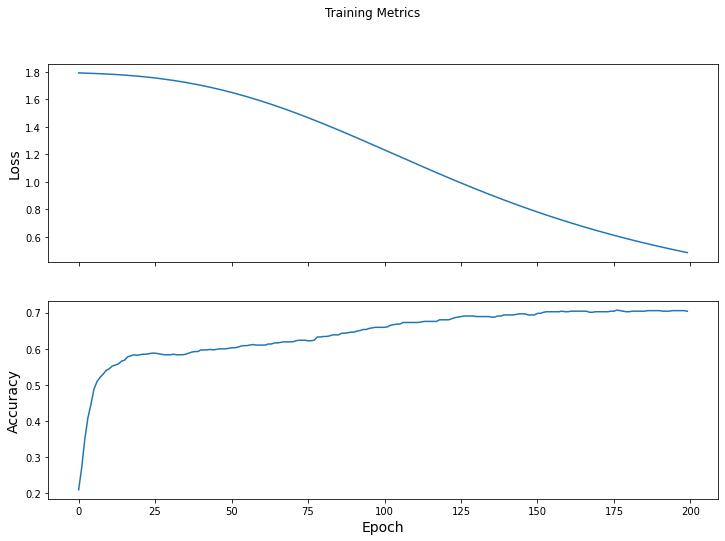

Test set accuracy: 71.386%


In [7]:
gcn_model = GCN_Model(features.shape[1], tf.unique(labels)[0].shape[0])

gcn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metric=tf.keras.metrics.SparseCategoricalAccuracy()
)

gcn_model.fit(adj, features, labels, train_mask, val_mask, 200)
acc = gcn_model.test_on_batch(adj, features, labels, test_mask)
print("Test set accuracy: {:.3%}".format(acc))

Epoch 000: Loss: 1.791, Accuracy: 19.940%
Epoch 001: Loss: 1.790, Accuracy: 20.982%
Epoch 002: Loss: 1.789, Accuracy: 23.363%
Epoch 003: Loss: 1.788, Accuracy: 27.083%
Epoch 004: Loss: 1.787, Accuracy: 29.613%
Epoch 005: Loss: 1.785, Accuracy: 31.994%
Epoch 006: Loss: 1.784, Accuracy: 32.292%
Epoch 007: Loss: 1.783, Accuracy: 35.119%
Epoch 008: Loss: 1.781, Accuracy: 36.161%
Epoch 009: Loss: 1.780, Accuracy: 37.202%
Epoch 010: Loss: 1.778, Accuracy: 38.244%
Epoch 011: Loss: 1.777, Accuracy: 39.435%
Epoch 012: Loss: 1.775, Accuracy: 40.327%
Epoch 013: Loss: 1.773, Accuracy: 40.923%
Epoch 014: Loss: 1.772, Accuracy: 41.369%
Epoch 015: Loss: 1.770, Accuracy: 42.708%
Epoch 016: Loss: 1.768, Accuracy: 43.899%
Epoch 017: Loss: 1.766, Accuracy: 44.494%
Epoch 018: Loss: 1.763, Accuracy: 45.238%
Epoch 019: Loss: 1.761, Accuracy: 45.387%
Epoch 020: Loss: 1.759, Accuracy: 46.726%
Epoch 021: Loss: 1.756, Accuracy: 47.470%
Epoch 022: Loss: 1.753, Accuracy: 48.065%
Epoch 023: Loss: 1.750, Accuracy: 

Epoch 198: Loss: 0.273, Accuracy: 62.054%
Epoch 199: Loss: 0.269, Accuracy: 62.054%


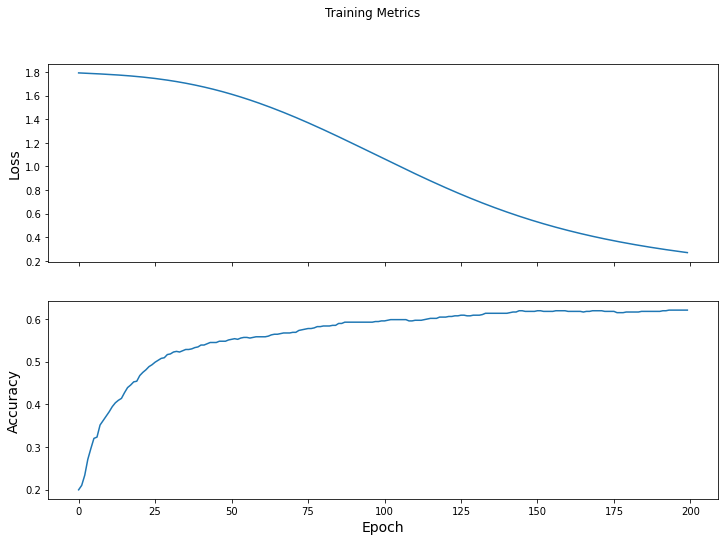

Test set accuracy: 66.276%


In [8]:
mlp_model = MLP_Model(feature_len, label_len)

mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metric=tf.keras.metrics.SparseCategoricalAccuracy()
)

mlp_model.fit(features, labels, train_mask, val_mask, 200)
acc = mlp_model.test_on_batch(features, labels, test_mask)
print("Test set accuracy: {:.3%}".format(acc))

In [9]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(8*16, activation=tf.nn.relu, input_shape=(features.shape)),
  tf.keras.layers.Dense(tf.unique(labels)[0].shape[0]),
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())
model.fit(
    features[train_mask], 
    labels[train_mask], 
    validation_data=(features[val_mask], labels[val_mask]), 
    epochs=200
)

loss, acc = model.test_on_batch(features, labels)
print("Test set accuracy: {:.3%}".format(acc))

Epoch 1/200


2022-04-27 02:12:10.139609: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


12/12 [==============================] - 1s 40ms/step - loss: 1.7781 - sparse_categorical_accuracy: 0.1797 - val_loss: 1.7174 - val_sparse_categorical_accuracy: 0.2202
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 1.6107 - sparse_categorical_accuracy: 0.4285 - val_loss: 1.6246 - val_sparse_categorical_accuracy: 0.3795
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 1.3417 - sparse_categorical_accuracy: 0.8398 - val_loss: 1.4479 - val_sparse_categorical_accuracy: 0.6176
Epoch 4/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9037 - sparse_categorical_accuracy: 0.8880 - val_loss: 1.2729 - val_sparse_categorical_accuracy: 0.5967
Epoch 5/200
12/12 [==============================] - 0s 4ms/step - loss: 0.4777 - sparse_categorical_accuracy: 0.9601 - val_loss: 1.0997 - val_sparse_categorical_accuracy: 0.6667
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 0.2122 - sparse_categorical_accuracy: 0.986

12/12 [==============================] - 0s 4ms/step - loss: 6.3706e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1738 - val_sparse_categorical_accuracy: 0.6354
Epoch 45/200
12/12 [==============================] - 0s 4ms/step - loss: 5.3284e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1717 - val_sparse_categorical_accuracy: 0.6384
Epoch 46/200
12/12 [==============================] - 0s 4ms/step - loss: 6.0701e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1718 - val_sparse_categorical_accuracy: 0.6369
Epoch 47/200
12/12 [==============================] - 0s 4ms/step - loss: 5.2694e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1692 - val_sparse_categorical_accuracy: 0.6414
Epoch 48/200
12/12 [==============================] - 0s 4ms/step - loss: 5.1929e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1699 - val_sparse_categorical_accuracy: 0.6429
Epoch 49/200
12/12 [==============================] - 0s 4ms/step - loss: 5.1843e-04 - sparse

12/12 [==============================] - 0s 4ms/step - loss: 1.3579e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2463 - val_sparse_categorical_accuracy: 0.6414
Epoch 89/200
12/12 [==============================] - 0s 4ms/step - loss: 1.5419e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2476 - val_sparse_categorical_accuracy: 0.6414
Epoch 90/200
12/12 [==============================] - 0s 4ms/step - loss: 1.2725e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2489 - val_sparse_categorical_accuracy: 0.6414
Epoch 91/200
12/12 [==============================] - 0s 4ms/step - loss: 1.4044e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2502 - val_sparse_categorical_accuracy: 0.6414
Epoch 92/200
12/12 [==============================] - 0s 4ms/step - loss: 1.2629e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2524 - val_sparse_categorical_accuracy: 0.6414
Epoch 93/200
12/12 [==============================] - 0s 4ms/step - loss: 1.2770e-04 - sparse

12/12 [==============================] - 0s 5ms/step - loss: 4.9507e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3210 - val_sparse_categorical_accuracy: 0.6369
Epoch 133/200
12/12 [==============================] - 0s 5ms/step - loss: 5.0896e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3222 - val_sparse_categorical_accuracy: 0.6384
Epoch 134/200
12/12 [==============================] - 0s 4ms/step - loss: 5.4294e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3237 - val_sparse_categorical_accuracy: 0.6384
Epoch 135/200
12/12 [==============================] - 0s 5ms/step - loss: 4.9757e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3247 - val_sparse_categorical_accuracy: 0.6384
Epoch 136/200
12/12 [==============================] - 0s 6ms/step - loss: 4.7639e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3265 - val_sparse_categorical_accuracy: 0.6369
Epoch 137/200
12/12 [==============================] - 0s 5ms/step - loss: 4.6416e-05 - s

12/12 [==============================] - 0s 5ms/step - loss: 2.5521e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3797 - val_sparse_categorical_accuracy: 0.6354
Epoch 177/200
12/12 [==============================] - 0s 5ms/step - loss: 2.4458e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3813 - val_sparse_categorical_accuracy: 0.6354
Epoch 178/200
12/12 [==============================] - 0s 5ms/step - loss: 2.6352e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3829 - val_sparse_categorical_accuracy: 0.6354
Epoch 179/200
12/12 [==============================] - 0s 5ms/step - loss: 2.4381e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3841 - val_sparse_categorical_accuracy: 0.6369
Epoch 180/200
12/12 [==============================] - 0s 5ms/step - loss: 2.2308e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3851 - val_sparse_categorical_accuracy: 0.6384
Epoch 181/200
12/12 [==============================] - 0s 5ms/step - loss: 2.2713e-05 - s